In [13]:
import matplotlib.pyplot as plt, numpy as np, joblib, os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from stellarutil import Simulation, Star
from concurrent.futures import ThreadPoolExecutor

SIMULATION = 'm10r_res250md' # The simulation to load
X=[] # The input for the ML model
Y=[] # The output for the ML model
USE_PICKLE = True # Should X and Y be retrieved from the pickle files

if USE_PICKLE and os.path.exists(f"../pickle/{SIMULATION}_X.pkl") and os.path.exists(f"../pickle/{SIMULATION}_y.pkl"):
    X = joblib.load(f"../pickle/{SIMULATION}_X.pkl")
    Y = joblib.load(f"../pickle/{SIMULATION}_Y.pkl")
else:
    # Get the halo at index 0 restricted at 100%
    m10v_res30 = Simulation(simulation_name=SIMULATION, species=['star', 'dark'])
    halo = m10v_res30.get_halo()
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    dark_x = m10v_res30.particles['dark']['position'][:,0] - halo.xc
    dark_y = m10v_res30.particles['dark']['position'][:,1] - halo.yc
    dark_z = m10v_res30.particles['dark']['position'][:,2] - halo.zc
    # Get the mass of each dm particle in the simulation
    dark_m = m10v_res30.particles['dark']['mass']
    # Get the distance of each dm particle from the center of the indicated dark matter halo
    dark_distances = np.sqrt(np.square(dark_x) + np.square(dark_y) + np.square(dark_z))

    # Get X - the features used by the ML to predict Y
    for star in halo.stars:
        X.append([star.x, star.y, star.vz, star.a, star.get_3DR(), star.get_3DR()])

    # Find the dark matter masses of each star in the halo, using multiple threads
    with ThreadPoolExecutor(max_workers=12) as executor:
        def get_dm_mass(star: Star):
            dm_masses = dark_m[dark_distances < star.get_3DR()] # Filter out all dm that are farther than the star's r
            return np.sum(dm_masses) # dark matter mass is the mass of each particle whose r < r_star
    
        def process(star: Star):
            dm_mass = get_dm_mass(star)
            return dm_mass
        
        results = list(executor.map(process, halo.stars))
        
    # Get Y - the result of the multithreaded process
    for result in enumerate(results, start=1):
        index, data = result
        Y.append(data)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and train the KNN regressor
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.array(X_train) 
y_train = np.array(y_train)
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = np.array(knn_regressor.predict(X_test))

# Find the percent difference
sum = 0
list = []
for i in range(len(y_pred)):
    a = y_pred[i]
    b = y_test[i]
    r = round(X_test[i][4],3)
    p = round(100 * ((2 * abs(a-b)) / (a+b)), 3)
    sum = sum + p
    list.append((r, p))

print(f"Total Stars: { len(X) }")
print(f"Average Percent Difference: { round(sum / len(list), 3) }%")
print(f"Average Accuracy: { round(100 - sum / len(list), 3) }%")

def graph(x,y, title, r):
    x = np.array(x)
    y = np.array(y)
    # Create the scatter plot
    plt.scatter(x, y, label='Data Points', c=r, vmin=0.011, vmax=1.5)
    plt.colorbar()
    # Get the max and min value
    minVal = min(min(x), min(y))
    maxVal = max(max(x), max(y))
    # Plot y=x line
    plt.plot([minVal, maxVal], [minVal, maxVal], color='green', label='y = x')
    # Add labels and legend
    plt.xlabel('Actual Mass [M☉]')
    plt.ylabel('Predicted Mass [M☉]')
    plt.title(title)
    plt.legend()
    plt.loglog()
    # Show the plot
    plt.show()
    
# Graph
graph(y_test, y_pred, "Predicted vs Actual Dark Matter Mass", X_test[:,4])

Average Accuracy: -47.007%


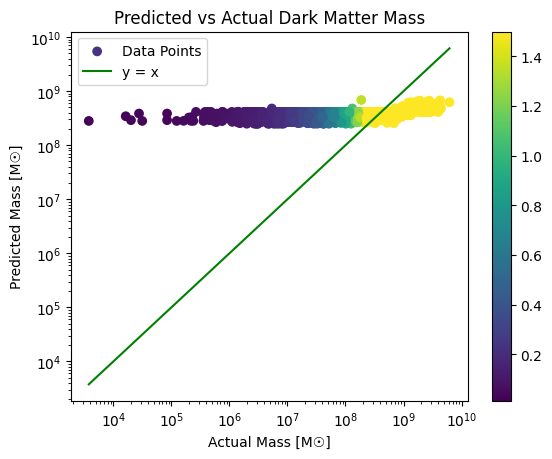

In [39]:
import joblib, numpy as np
# Load models
big_victor = joblib.load(f"../pickle/big_victor.pkl")
little_victor = joblib.load(f"../pickle/little_victor.pkl")
little_romeo = joblib.load(f"../pickle/little_romeo.pkl")
# Load X and Y for each model
X_big_victor = joblib.load(f"../pickle/m10v_res030md_X.pkl")
Y_big_victor = joblib.load(f"../pickle/m10v_res030md_Y.pkl")
X_little_victor = joblib.load(f"../pickle/m10v_res250md_X.pkl")
Y_little_victor = joblib.load(f"../pickle/m10v_res250md_Y.pkl")
X_little_romeo = joblib.load(f"../pickle/m10r_res250md_X.pkl")
Y_little_romeo = joblib.load(f"../pickle/m10r_res250md_Y.pkl")
# Choose the model and data to use
X = X_little_romeo
Y = Y_little_romeo
model = little_victor

X_test = np.array(X)
y_test = np.array(Y)
y_pred = np.array(model.predict(X_test))

def getAccuracy():
    # Find the percent difference
    sum = 0
    for i in range(len(y_pred)):
        a = y_pred[i]
        b = y_test[i]
        p = round(100 * ((2 * abs(a-b)) / (a+b)), 3)
        sum = sum + p
    # Accuracy is 100 - average percent difference
    return round(100 - sum / len(y_pred), 3)

def graph(x,y, title, r):
    x = np.array(x)
    y = np.array(y)
    # Create the scatter plot
    plt.scatter(x, y, label='Data Points', c=r, vmin=0.011, vmax=1.5)
    plt.colorbar()
    # Get the max and min value
    minVal = min(min(x), min(y))
    maxVal = max(max(x), max(y))
    # Plot y=x line
    plt.plot([minVal, maxVal], [minVal, maxVal], color='green', label='y = x')
    # Add labels and legend
    plt.xlabel('Actual Mass [M☉]')
    plt.ylabel('Predicted Mass [M☉]')
    plt.title(title)
    plt.legend()
    plt.loglog()
    # Show the plot
    plt.show()

print(f"Average Accuracy: { getAccuracy() }%")
graph(y_test, y_pred, "Predicted vs Actual Dark Matter Mass", X_test[:,4])

